# Mouse Training Notebook

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [14]:
import functools
import json
from datetime import datetime

import jax
from jax.experimental import checkify
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp
from tqdm import tqdm

from mujoco_playground import locomotion, wrapper
from mujoco_playground.config import locomotion_params

from vnl_mjx.tasks.mouse import mouse_reach
import jax.numpy as jnp

jax.config.update("jax_debug_nans", True)

# # Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [23]:
from ml_collections import config_dict

ppo_params = config_dict.create(
    num_timesteps=100_000_000,
    num_evals=10,
    reward_scaling=1.0,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=1e-4,
    entropy_cost=1e-4,
    num_envs=8192,
    batch_size=256,
    max_grad_norm=1.0,
    network_factory=config_dict.create(
        policy_hidden_layer_sizes=(512, 512, 512),
        value_hidden_layer_sizes=(512, 512, 512),
        policy_obs_key="state",
        value_obs_key="state",
    ),
)

env_name = "mouse-reach"

In [24]:
from pprint import pprint

ppo_params.num_evals = 150
ppo_params.num_envs = 2048
ppo_params.episode_length = 1000
ppo_params.num_timesteps = 0  # int(5e8)
pprint(ppo_params)

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.0001
episode_length: 1000
learning_rate: 0.0001
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 512
  - 512
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: state
normalize_observations: true
num_envs: 2048
num_evals: 150
num_minibatches: 32
num_timesteps: 0
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20



In [25]:
SUFFIX = None
FINETUNE_PATH = (
    "/root/vast/eric/vnl-mjx/checkpoints/mouse-reach-20250520-022333"
)

# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
    exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
    FINETUNE_PATH = epath.Path(FINETUNE_PATH)
    latest_ckpts = list(FINETUNE_PATH.glob("*"))
    latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
    latest_ckpts.sort(key=lambda x: int(x.name))
    latest_ckpt = latest_ckpts[-1]
    restore_checkpoint_path = latest_ckpt
    print(f"Restoring from: {restore_checkpoint_path}")
else:
    restore_checkpoint_path = None

Experiment name: mouse-reach-20250520-023733
Restoring from: /root/vast/eric/vnl-mjx/checkpoints/mouse-reach-20250520-022333/194805760


In [26]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def policy_params_fn(current_step, make_policy, params):
    del make_policy  # Unused.
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)


training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
    ppo.train,
    **training_params,
    network_factory=functools.partial(
        ppo_networks.make_ppo_networks, **ppo_params.network_factory
    ),
    restore_checkpoint_path=restore_checkpoint_path,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    policy_params_fn=policy_params_fn,
)

# env = flat_arena.FlatWalk()
# eval_env = flat_arena.FlatWalk()

env = mouse_reach.MouseEnv()
eval_env = mouse_reach.MouseEnv()
env.add_target(random_target=True)
eval_env.add_target(random_target=True)

make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)

/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [27]:
geoms = env._spec.worldbody.find_all(mujoco.mjtObj.mjOBJ_GEOM)
[g.name for g in geoms]

['', '', '', '', '', 'wrist_marker']

In [28]:
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [29]:
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

In [30]:
state =  jit_reset(jax.random.PRNGKey(0))


In [31]:
state.obs.shape

(11,)

In [32]:
params

(RunningStatisticsState(mean=Array([-1.3385800e-01, -3.6907098e-01,  1.2229100e+00,  6.3664995e-02,
        -1.9059724e-01, -1.0911378e+00,  5.0375142e+00, -4.6208364e-01,
        -9.3004387e-04,  2.6568240e-03,  1.8576314e-03], dtype=float32), std=Array([1.9896954e-01, 2.1873353e-01, 5.1554543e-01, 2.4603003e-01,
        3.6388769e+00, 4.1335578e+00, 7.5272427e+00, 4.0206976e+00,
        7.1759691e-04, 3.3147270e-03, 3.0812072e-03], dtype=float32), count=Array(1.9480576e+08, dtype=float32), summed_variance=Array([7.71214200e+06, 9.32035700e+06, 5.17768600e+07, 1.17917450e+07,
        2.57950592e+09, 3.32850995e+09, 1.10375741e+10, 3.14923187e+09,
        1.00314316e+02, 2.14041187e+03, 1.84945422e+03], dtype=float32)),
 {'params': {'hidden_0': {'bias': Array([ 2.02322826e-02, -2.29146481e-02, -3.24497409e-02,  1.68454517e-02,
           -2.27650683e-02, -1.37835685e-02, -3.21066119e-02, -1.31611899e-02,
           -2.43763030e-02, -1.54713662e-02, -4.81348485e-02, -1.74831261e-03,
   

In [33]:
# Make sure we actually collect rewards first
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
qfrc_constraint = []
qvels = []

for _ in range(1):
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)
    for i in tqdm(range(300)):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        actions.append(ctrl)
        state = jit_step(state, ctrl)
        rollout.append(state)
        rewards.append(float(state.reward))  # Convert to Python float for reliable plotting
        torso_height.append(state.data.qpos[2])
        torques.append(state.data.actuator_force)
        qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:33<00:00,  9.07it/s]


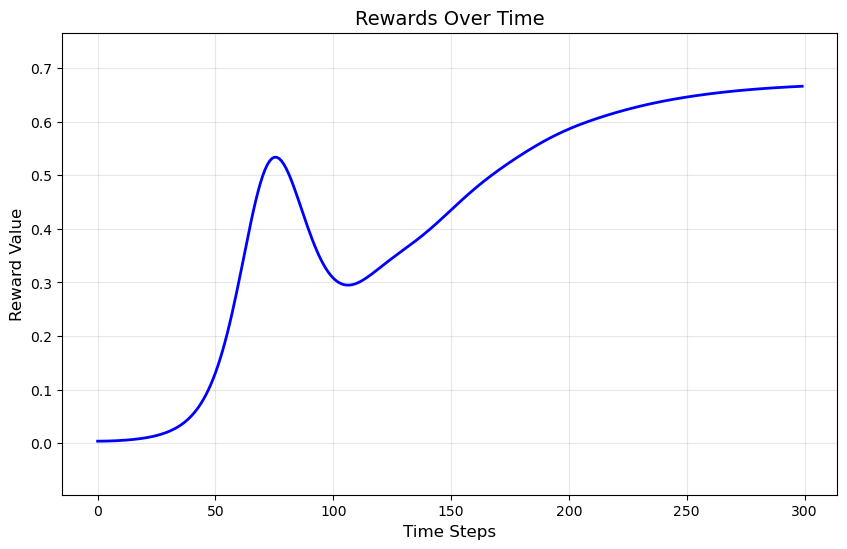

In [35]:
# Now plot the rewards with proper formatting
plt.figure(figsize=(10, 6))
plt.plot(rewards, 'b-', linewidth=2)
plt.title('Rewards Over Time', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Reward Value', fontsize=12)
plt.grid(True, alpha=0.3)
if len(rewards) > 0:
    plt.ylim([min(rewards) - 0.1, max(rewards) + 0.1])
plt.show()

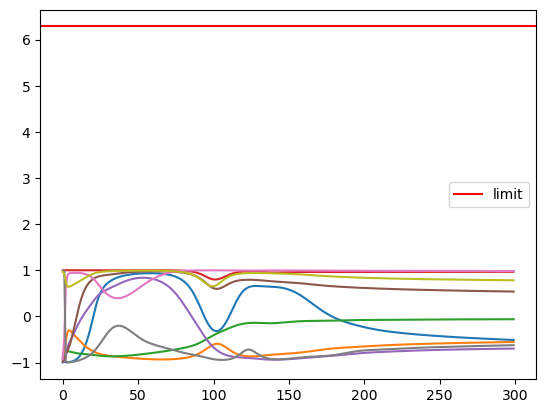

In [36]:
plt.plot(actions)
plt.axhline(2 * jp.pi, color="red", label="limit")
plt.legend()
plt.show()

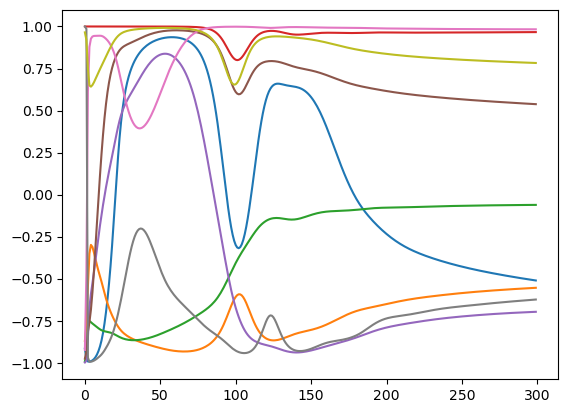

In [37]:
plt.plot(actions)

In [38]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj,
    camera="close_profile",
    scene_option=scene_option,
    height=480,
    width=640,
)
media.show_video(frames, fps=fps * 2, loop=False)
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)

100%|██████████| 150/150 [00:00<00:00, 469.62it/s]
